<a href="https://colab.research.google.com/github/cddaaaa1/deep-learning-course/blob/master/03_Network_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Network Training

In this tutorial, we introduce different topics related to the training of deep neural networks, including data augmentation, optimization/regularization techniques, weight initializations and hyperparameters tuning.


# New Section

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pickle
from tabulate import tabulate
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preliminary

We load the MNIST dataset and define a model for digit classification by using our own function `get_data_model`. We also define a new function `plot_history`, which plots the training loss and, if required, the validation loss. We will use these functions throughout the tutorial.

In [ ]:
def plot_history(history, metric = None):
  # Plots the loss history of training and validation (if existing)
  # and a given metric
  # Be careful because the axis ranges are automatically adapted
  # which may not desirable to compare different runs.
  # Also, in some cases you may want to combine several curves in one
  # figure for easier comparison, which this function does not do.

  if metric != None:
    fig, axes = plt.subplots(2,1)
    axes[0].plot(history.history[metric])
    try:
      axes[0].plot(history.history['val_'+metric])
      axes[0].legend(['Train', 'Val'])
    except:
      pass
    axes[0].set_title('{:s}'.format(metric))
    axes[0].set_ylabel('{:s}'.format(metric))
    axes[0].set_xlabel('Epoch')
    fig.subplots_adjust(hspace=0.5)
    axes[1].plot(history.history['loss'])
    try:
      axes[1].plot(history.history['val_loss'])
      axes[1].legend(['Train', 'Val'])
    except:
      pass
    axes[1].set_title('Model Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
  else:
    plt.plot(history.history['loss'])
    try:
      plt.plot(history.history['val_loss'])
      plt.legend(['Train', 'Val'])
    except:
      pass
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

def get_data_model(args = {}):
  # Returns simple model, flattened MNIST data and categorical labels
  num_classes=10

  # the data, shuffled and split between train and test sets
  (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
  x_train = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
  x_test = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])

  x_train= x_train.astype('float32')
  x_test= x_test.astype('float32')

  x_train /= 255
  x_test /= 255

  y_train=keras.utils.to_categorical(y_train,num_classes)
  y_test=keras.utils.to_categorical(y_test,num_classes)

  # Load a simple non-convolutional model
  model = keras.models.Sequential()
  model.add(keras.layers.Input(shape=(784,)))
  model.add(keras.layers.Dense(512, activation='relu', **args))
  model.add(keras.layers.Dense(512, activation='relu', **args))
  model.add(keras.layers.Dense(10, activation='softmax', **args))
  return model, x_train, y_train, x_test, y_test

model, x_train, y_train, x_test, y_test = get_data_model()
model.summary()


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │         401,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 669,706 (2.55 MB)

 Trainable params: 669,706 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

## Optimizers

In a deep learning problem, the weights of a network are updated to minimize the loss in each optimization step. Optimizers define the specific method used to update in each timestep the weights of the network. For example, the vanilla Stochastic Gradient Descent (SGD) only uses the gradient of the weight with respect to the loss in the current timestep $t$, along with the learning rate, to update the weights. However, other optimizers use more sophisticate methods (e.g., keeping track of past gradient updates to use as momentum) to compute the weights' updates.

Since there are optimizers more prone to get stuck in local minima, the choice of the optimizer can potentially affect both the final performance and the speed of convergence.  A nice visualization of such behavior is the following animation, where you can notice some methods, i.e., Adadelta (yellow), and Rmsprop (black) converge significantly faster than SGD (red), which gets stuck in a local minimum.

![](http://ruder.io/content/images/2016/09/saddle_point_evaluation_optimizers.gif)

The animation above is from [Sebastian Ruder's blog](http://ruder.io/optimizing-gradient-descent/), who wrote an interesting article showing the formulation and properties of the different optimizers. We are not going to analyze the properties of the different optimizers, but you can read the blog post if you are interested in how optimizers work. As a rule of thumb, Adam is usually easier to tune due to the adaptive learning rate, whereas SGD with momentum [has been shown](https://arxiv.org/pdf/1712.07628.pdf) to reach better results when tuned correctly.

In this tutorial, we will follow a hands-on approach and will mainly focus on how to use them in Keras. The official documentation [Optimizers in Keras](https://keras.io/optimizers/) lists all the available optimizers. The optimizer we use is passed as an argument to the `compile` function after we build our model. An easy way to do so is passing the optimizer in the form of a string, which will use the default parameters.  For example, in the next piece of code we use Adam with the default Keras parameters as our optimizer.

In [ ]:
model, x_train, y_train, x_test, y_test = get_data_model()
model.compile(optimizer='adam',loss='categorical_crossentropy')
model.fit(x_train,y_train,batch_size=100, epochs=10, verbose=1,validation_data=(x_test,y_test))

Epoch 1/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3822 - val_loss: 0.0963
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0771 - val_loss: 0.0783
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0493 - val_loss: 0.0740
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0355 - val_loss: 0.0823
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0257 - val_loss: 0.0777
Epoch 6/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0215 - val_loss: 0.0781
Epoch 7/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0143 - val_loss: 0.0915
Epoch 8/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0195 - val_loss: 0.0828
Epoch 9/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0138 - val_loss: 0.0900
Epoch 10/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0142 - val_loss: 0.0981


However, it is quite usual to change some of the parameters of the optimizer, such as the learning rate, which controls the update rate of the weights, depending on the problem we are trying to solve. To do so in Keras, instead of passing a string to the `compile` function, we can pass an object with our optimizer with custom parameters. For example, in the following code, we use Adam optimizer with a different learning rate.

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=3e-4)
model, x_train, y_train, x_test, y_test = get_data_model()
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
model.fit(x_train,y_train,batch_size=100, epochs=10, verbose=1,validation_data=(x_test,y_test))

Epoch 1/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.5636 - val_loss: 0.1463
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1216 - val_loss: 0.0956
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0725 - val_loss: 0.0781
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0522 - val_loss: 0.0679
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0353 - val_loss: 0.0672
Epoch 6/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0252 - val_loss: 0.0634
Epoch 7/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0189 - val_loss: 0.0647
Epoch 8/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0138 - val_loss: 0.0716
Epoch 9/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0111 - val_loss: 0.0734
Epoch 10/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0090 - val_loss: 0.0774


## Initializers


Neural Networks have a large number of weights that need to be initialized properly. Weight initialization is a crucial step in tuning neural networks as different initial values can lead the model to reach different local minima. If your initial weights are too small, the network may have problems learning due to small/vanishing gradients. However, if they are too large, you may run into exploding gradients or you could saturate an activation in the network (e.g. a sigmoid). Hence, we need a proper initialization with not too large nor not too small weights. In [this link](https://www.deeplearning.ai/ai-notes/initialization/) you can find an explanation of the importance of weight initialization.  The weights are usually randomly initialized by different algorithms, e.g. Xavier, He_normal or LeCun, all of them theoretically motivated to have specific properties following different assumptions.

In Keras, you can set the particular initialization strategy you want to use as an argument when declaring a layer. The available initialization methods in Keras are listed [here](https://keras.io/api/layers/initializers/).  The initializers are passed to the layers via the arguments `kernel_initializer` and `bias_initializer`. For instance, in the function `Dense()`, which defines the mapping $y= Ax + b$, you can initialize the kernel values ($A$ in the equation) with a normal distribution (by default the `stddev` is 0.05) and the bias ($b$ in the equation) with $0$ using the code below.

In [ ]:
linear_layer = keras.layers.Dense(64, kernel_initializer='random_normal',
                bias_initializer='zeros')

Now let's check the weights of the layers and see if they follow the distributions we set.

In [ ]:
input_x = tf.Variable(np.random.random((1, 64)))
y = linear_layer(input_x)
weights = linear_layer.get_weights()
# Weights return an array with [kernel, bias]
# Let's see the kernel weights
print(weights[0])

[[ 0.07510946  0.08990149 -0.03298217 ... -0.0168688   0.00206932
   0.02027493]
 [ 0.02943959 -0.03316227 -0.05959177 ... -0.11213149 -0.00854681
   0.03670555]
 [ 0.0512074  -0.00218907 -0.03729281 ... -0.02433882 -0.03343663
   0.04645128]
 ...
 [ 0.04852905 -0.11025394 -0.04793274 ... -0.02706775  0.01123823
  -0.02092767]
 [-0.0470003   0.00012322 -0.04424356 ...  0.06766386  0.03509251
   0.09700523]
 [ 0.07531791 -0.06274601 -0.02395883 ...  0.04597552  0.00149923
   0.02476267]]


In [ ]:
# Now let's check that the mean is 0 and stddev is 0.05
print(weights[0].mean(), weights[0].std())

0.00012788927 0.05009352


In [ ]:
# Let's print the bias now
print(weights[1])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


By default the kernel weights are initialized as `'glorot_uniform'` and the bias to `'zeros'`. Glorot Uniform, which is also called Xavier Uniform initialization, was defined [here](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf). The Xavier Uniform initialization samples the weights from a uniform distribution, whose range depends on the number of input and output units. Another initializer quite used is the `he_normal`, which draws the weights from a truncated normal distribution. Usually, the initialization used by default in Keras works quite well and allows the model to train properly.

## Loss

Another important step in training deep neural networks is the choice of the loss function, which strictly depends on your problem. The full list of standard losses in Keras is available [here](https://keras.io/losses/). Although in past tutorials we already used some losses, we now introduce two typical losses, cross-entropy and mean squared error, for two standard problems in machine learning: classification and regression.

### Classification

For classification problems, the standard loss used is the cross-entropy loss. For the binary case, the formula is $\mathcal{L} = y\log(p) + (1-y)\log(1-p)$, where $p$ is a probability value between $[0, 1]$.
Typically a [Sigmoid activation](https://en.wikipedia.org/wiki/Sigmoid_function) is applied in the binary case to constrain the activations to force the output value to be between $[0, 1]$. In Keras, the presented binary classification loss is called `binary_crossentropy`, and it accepts as target a vector with an element in the range $[0, 1]$ (usually either $0$ or $1$) per input element. We show in the following code an example of binary classification. To do so, we transform MNIST into a binary classification problem by classifying if a number is between 0-4 or 5-9.

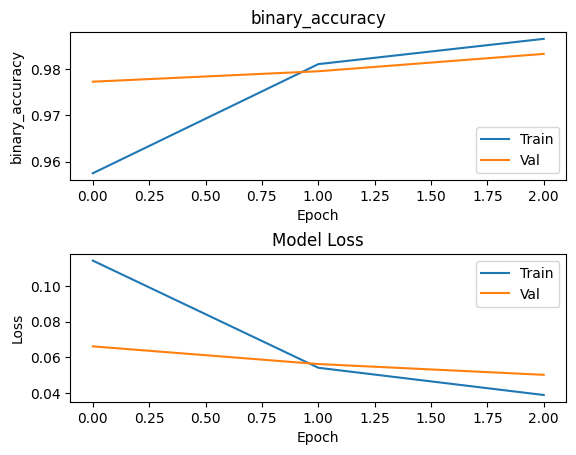

In [ ]:
model, x_train, y_train, x_test, y_test = get_data_model()
model.pop()
model.add(keras.layers.Dense(1, activation='sigmoid'))

# This three lines transform the problem in a binary one
# We want to know if the number is bigger than 5 (label 1) or smaller (label 0)
y_train = np.argmax(y_train, axis = 1)
y_train[y_train < 5] = 0
y_train[y_train >= 5] = 1


model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['binary_accuracy'])
history = model.fit(x_train, y_train, epochs=3, batch_size=32,  validation_split=0.2, verbose = 0)
plot_history(history, 'binary_accuracy')

When the number of classes is higher than 2, we use the cross-entropy loss, which is $\mathcal{L} = -\sum_i y_i\log(p_i)$. The loss is called `categorical_crossentropy` in Keras and accepts one-hot encoded vectors. A one-hot encoded vector has dimensionality $C$, where $C$ is the number of classes. All of the elements are set to 0, minus the corresponding class $c$, which is set to 1. If we have a vector of labels with a scalar from $[0, C)$ per training example, we can transform it into a one-hot encoding form by using the function `to_categorical`.  

Let's see an example using MNIST data.

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
# The labels are an scalar from 0 to 9 per example
one_hot_vector = keras.utils.to_categorical(y_train[:5])
for i in range(5):
  print('Label Value: {}. One-hot encoded vector: {}\n'.format(y_train[i], one_hot_vector[i]))

Label Value: 5. One-hot encoded vector: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]

Label Value: 0. One-hot encoded vector: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Label Value: 4. One-hot encoded vector: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]

Label Value: 1. One-hot encoded vector: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]

Label Value: 9. One-hot encoded vector: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]



The input for the cross-entropy needs to be a probability distribution, meaning that the sum of the elements should be $\sum_i p_i = 1$. To make the output vector of our model add up to 1, we use the [Softmax activation](https://en.wikipedia.org/wiki/Softmax_function)  function as shown in the following code cell.

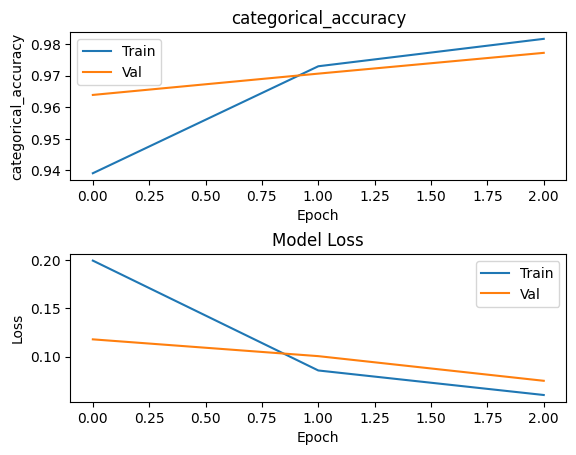

In [ ]:
# We use the function get_data_model, which already applies to_categorical
_, x_train, y_train, x_test, y_test = get_data_model()

### Model defined with softmax
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(784,)))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history = model.fit(x_train, y_train, epochs=3, batch_size=32,  validation_split=0.2, verbose = 0)
plot_history(history, 'categorical_accuracy')

If you prefer to provide the label as an integer instead of doing the one-hot transformation, you can use the ``sparse_categorical_crossentropy`` loss in Keras.

### Regression
In regression problems, it is common to use as losses the Mean Squared Error (MSE) or Mean Absolute Error (MAE). We now show a quick example using the Boston Housing dataset, which contains a set of input features and we aim to predict the price of the house.

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.boston_housing.load_data()
print(y_train[:10])

[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4]


We see that the labels are float numbers (the price of the house), and our goal is to predict those float numbers. To do so, we need a network that has only one output. In the following code cells, we will train a network using either MAE or MSE. First, we use MAE.

In [ ]:
model_mae = keras.models.Sequential()
model_mae.add(keras.layers.Input(shape=(13,)))
model_mae.add(keras.layers.Dense(100, activation='relu'))
model_mae.add(keras.layers.Dense(1))
model_mae.compile(optimizer='adam',loss='mean_absolute_error', metrics=['mean_absolute_error', 'mean_squared_error'])
history = model_mae.fit(x_train, y_train, epochs=100, batch_size=32,  validation_split=0.2, verbose = 0)

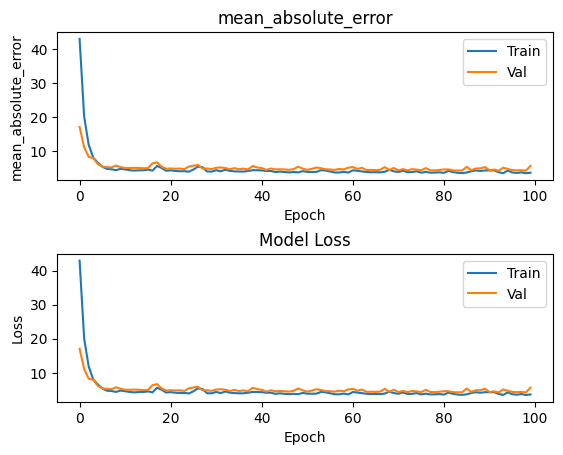

In [ ]:
plot_history(history, 'mean_absolute_error')

Now we use the MSE loss:

In [ ]:
model_mse = keras.models.Sequential()
model_mse.add(keras.layers.Input(shape=(13,)))
model_mse.add(keras.layers.Dense(100, activation='relu'))
model_mse.add(keras.layers.Dense(1))
model_mse.compile(optimizer='adam',loss='mean_squared_error', metrics=['mean_absolute_error', 'mean_squared_error'])
history = model_mse.fit(x_train, y_train, epochs=100, batch_size=32,  validation_split=0.2, verbose = 0)

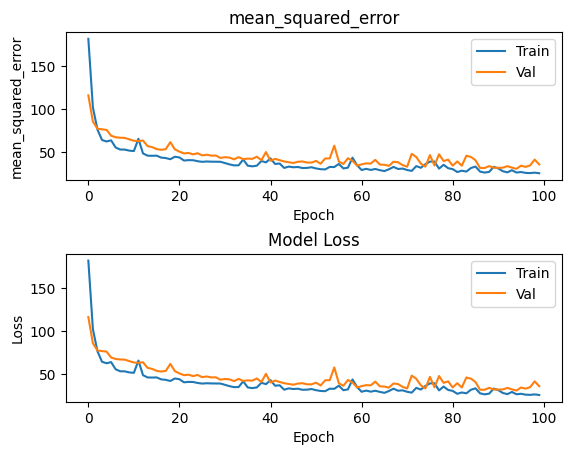

In [ ]:
plot_history(history, 'mean_squared_error')

In [ ]:
results = model_mae.evaluate(x_test, y_test)
print('MAE trained model achieves MAE: {:.4f} and MSE: {:.4f}'.format(results[1], results[2]))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 5.1411 - mean_absolute_error: 5.1411 - mean_squared_error: 50.4550
MAE trained model achieves MAE: 5.3533 and MSE: 54.6887


In [ ]:
results = model_mse.evaluate(x_test, y_test)
print('MSE trained model achieves MAE: {:.4f} and MSE: {:.4f}'.format(results[1], results[2]))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 30.1870 - mean_absolute_error: 3.7028 - mean_squared_error: 30.1870
MSE trained model achieves MAE: 3.9057 and MSE: 32.9821


The resulting plots show that training using MSE as loss achieves a better MSE and worse MAE in the test set compared to the model training with MAE loss, which is a sensible result.

A problem usually treated as a regression problem with deep learning approaches is depth estimation, where the depth of an image is estimated using the RGB information. Some other regression losses are also used in some settings (e.g. Huber loss or Reverse Huber loss, or the already introduced Mean Percentage Absolute Error), but MAE and MSE are widely used.

## Regularization
As mentioned in the lecture, regularization is an effective tool to fight some of the problems we may have during training, such as vanishing/exploding gradients or overfitting to the training set. We now mention some of the usual ways to regularize our training process.

### Loss Regularizers

[Regularizers](https://keras.io/regularizers/)  put some penalties to the optimization process. In practice, by penalizing large values, weights are constrained to be smaller in magnitude, which reduces the capacity of the model and can help us prevent overfitting.

In Keras, regularization works on a per-layer basis. Hence, you can define a regularization function for each layer. You can specify three regularization parameters, each one related to a different type of penalty. If we define the output of a layer as $y=Wx+b$, then:

*   `kernel_regularizer`: a penalty applied to the kernel weights. Larger regularization values result in smaller $W$.
*   `bias_regularizer`: a penalty applied to the bias of the network. Larger regularization values result in smaller $b$.
*   `activity_regularizer`: a penalty applied to the output of the layer. Larger regularization values result in smaller outputs $y=Wx+b$.

Standard regularizers that can be applied are $l_1$, $l_2$ and $l_1+l_2$.
In the example below, we check the difference in training and validation accuracy by varying the used regularization strategy.


Training with regularization value of 0.001000
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9151 - loss: 0.6941
Training with regularization value of 0.000000
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9806 - loss: 0.0780


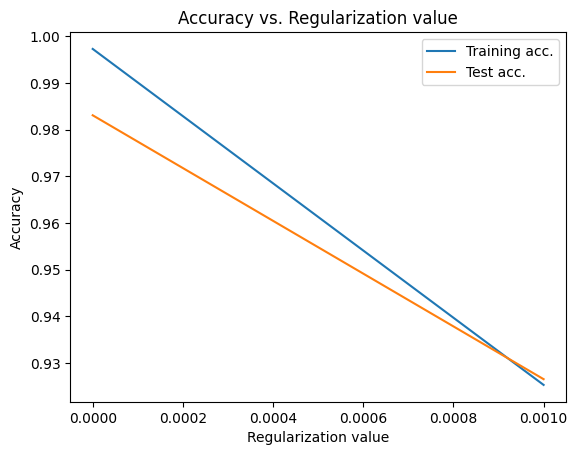

In [ ]:
test_accuracy = []
train_accuracy = []
reg_values = [0.001, 0.0]

for reg_val in reg_values:
  print('Training with regularization value of {:f}'.format(reg_val))
  args_dict = {'kernel_regularizer': keras.regularizers.l1(reg_val)}
  model, x_train, y_train, x_test, y_test = get_data_model(args_dict)
  model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
  history = model.fit(x_train, y_train, epochs=10, batch_size=256, verbose=0)
  train_accuracy.append(history.history['accuracy'][-1])
  test_accuracy.append(model.evaluate(x_test, y_test)[-1])

plt.figure()
plt.plot(reg_values, train_accuracy)
plt.plot(reg_values, test_accuracy)
plt.legend(['Training acc.', 'Test acc.'])
plt.title('Accuracy vs. Regularization value')
plt.ylabel('Accuracy')
plt.xlabel('Regularization value')
plt.show()

In this example, we show how a large regularization value dropped the final test accuracy, and also reduced the gap between training and test accuracy. The reason is that large regularization values put a constraint on the possible weights learnt by the network, which reduces the model capacity. Hence, you need to be careful when using regularization techniques as a large value can actually hurt the performance of the network.

### Dropout

Dropout is another regularization technique that can be applied to the network. Dropout is a layer that, during training, randomly deactivates some of the neurons of the model, which restricts the model from relying too much on specific patterns. The dropout value, i.e., the probability of disabling any given feature element, is a parameter set when defining the layer. In the evaluation phase, dropout does not have any effect on the model. The dropout layer implemented on Keras also scales during training the non-zero elements by $1/(1-p_{drop})$ to maintain a similar data magnitude between training and evaluation.

We now show an example using a dropout value is 0.3.

In [ ]:
prob_drop = 0.3
drop = keras.layers.Dropout(prob_drop)

In [ ]:
x = np.random.random((1, 512))
input_x = tf.Variable(x)
y = drop(input_x, training=True)
print('Input (10 elements)')
print(x[0,0:10])
print('Output (10 elements)')
print(y[0,0:10])

Input (10 elements)
[0.59610794 0.40208127 0.06453425 0.14015731 0.97030957 0.73986795
 0.23527997 0.6608239  0.71725544 0.3446755 ]
Output (10 elements)
tf.Tensor(
[0.8515828  0.57440186 0.09219179 0.20022474 0.         1.0569541
 0.33611426 0.94403416 1.0246506  0.        ], shape=(10,), dtype=float32)


We now check what percentage of elements have been set to 0, and what is the scaling value the other elements have.

In [ ]:
# Calculate drop percentage
print('Drop percentage, should be close to {:f}'.format(prob_drop))
print(tf.reduce_sum(tf.cast(y == 0, tf.float32)) / tf.cast(y.shape[1], tf.float32))

# Calculate scaling value
print('Scaling value, should be {:f}'.format(1/(1-prob_drop)))
# For non-zero elements
nonzero_mask = tf.not_equal(y, 0)
# Cast both tensors to the same type (float32)
y_masked = tf.cast(tf.boolean_mask(y, nonzero_mask), tf.float32)
x_masked = tf.cast(tf.boolean_mask(x, nonzero_mask), tf.float32)
scaling_value = tf.reduce_sum(y_masked) / tf.reduce_sum(x_masked)
print(scaling_value)

Drop percentage, should be close to 0.300000
tf.Tensor(0.30078125, shape=(), dtype=float32)
Scaling value, should be 1.428571
tf.Tensor(1.4285713, shape=(), dtype=float32)


Similarly to any of the past layers we have introduced, we can add a Dropout layer to any model using:

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Dropout(0.3))

Now we show the training curves of a model without dropout and a model with dropout. First, without dropout:

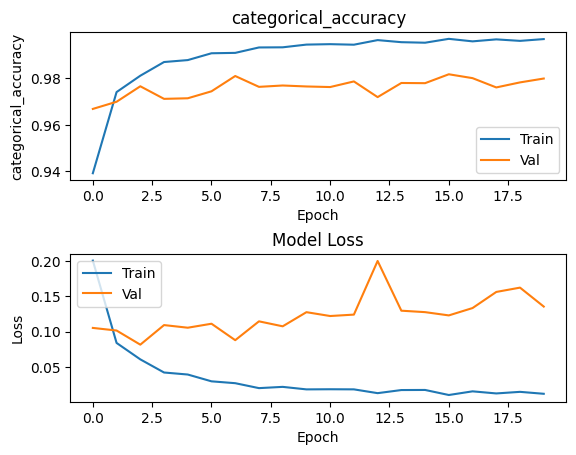

In [ ]:
model, x_train, y_train, x_test, y_test = get_data_model()
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)
plot_history(history, 'categorical_accuracy')

Now we add Dropout.

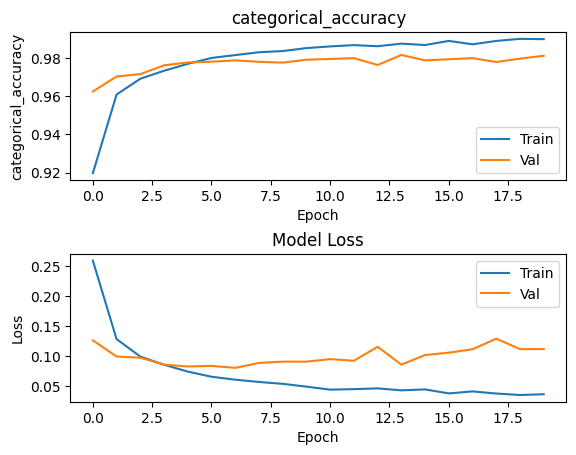

In [ ]:
_, x_train, y_train, x_test, y_test = get_data_model()
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(784,)))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)
plot_history(history, 'categorical_accuracy')

Notice how the validation loss stays closer to the training loss in the model with dropout compared to the original model.

### Batch Normalization

Batch Normalization normalizes the features by centering them around zero and rescaling them to have variance 1, which leads to faster and more stable training. To do so, batch normalization uses the statistics of the batch. Specifically, a batch normalization layer computes the mean and the standard deviation per channel, i.e. given a feature map of dimensionality $B\times H\times W\times C$ ($B$ is batch size, $H,W$ spatial dimensions and $C$ number of feature channels) the layer computes the mean $\mu$ and standard deviation $\sigma$ of the channels, where $\mu$ and $\sigma$ have dimensionality $1\times 1\times 1\times C$. Then, the mean $\mu$ and the standard deviation $\sigma$ of the batch are expanded again to $B\times H\times W\times C$ and used to standardize the input features to follow a distribution with mean 0 and variance 1. The layer output is then $y = \gamma\frac{x-\mu}{\sigma} + \beta$, where $\gamma$ and $\beta$ are learnable parameters that give the network more capacity to express different distributions.
The layer is defined in Keras by using:

In [ ]:
batch_norm = keras.layers.BatchNormalization(axis=-1)

Now we will generate a batch of 512x1 (a batch of 512 vectors of only 1 channel) using `np.random.random`, which is a uniform distribution under the $[0, 1)$ interval, resulting in mean 0.5 and variance 1/12. We will see how the batch normalization layer will scale the distribution to have mean 0 and variance 1.



In [ ]:
x = np.random.random((512, 10, 10, 1))
input_x = tf.Variable(x)
y = batch_norm(input_x, training=True)
print('Input')
print(x[:10, 0, 0, 0])
print('Output')
print(y[:10, 0, 0, 0])

Input
[0.86478573 0.4104446  0.93383501 0.75384997 0.53194622 0.87411554
 0.9474686  0.21599865 0.31442679 0.23482528]
Output
tf.Tensor(
[ 1.2642508  -0.30654347  1.502975    0.8807125   0.11352432  1.2965069
  1.5501103  -0.9788018  -0.63850605 -0.91371244], shape=(10,), dtype=float32)


In [ ]:
# Input mean should be ~0.5 and var ~1/12=0.0833
print(x.mean(), x.var())
# Output mean should be ~0 and var ~1
print(tf.reduce_mean(y), tf.math.reduce_variance(y))

0.4991101463976839 0.08266146830002494
tf.Tensor(6.15418e-08, shape=(), dtype=float32) tf.Tensor(0.9880472, shape=(), dtype=float32)


It is important to note that batch normalization changes behaviour in evaluation mode. During training, the layer tracks and updates the moving average of $\mu$ and $\sigma$ given all possible training batches. $\mu$ and $\sigma$ are then used to normalize the testing data without using the statistics from the testing batch.

Generally, using Batch Normalization results in faster training and easier convergence. It is quite standard to place Batch Normalization layers just before the activation function, but we can also achieve good performance by placing it after the activation function. So you can see blocks of Conv+BN+Activation or Conv+Activation+BN in different networks.

You can add your Batch Normalization layer as any other layer in your sequential model:

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.BatchNormalization())

Now we test the layer following a similar example as in the original [paper](http://proceedings.mlr.press/v37/ioffe15.pdf). We use a similar fully-connected model with sigmoid activations for MNIST.

Epoch 1/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - categorical_accuracy: 0.6060 - loss: 1.2861 - val_categorical_accuracy: 0.9163 - val_loss: 0.2941
Epoch 2/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - categorical_accuracy: 0.9228 - loss: 0.2705 - val_categorical_accuracy: 0.9425 - val_loss: 0.2005
Epoch 3/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - categorical_accuracy: 0.9486 - loss: 0.1777 - val_categorical_accuracy: 0.9567 - val_loss: 0.1495
Epoch 4/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - categorical_accuracy: 0.9631 - loss: 0.1313 - val_categorical_accuracy: 0.9605 - val_loss: 0.1339
Epoch 5/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - categorical_accuracy: 0.9699 - loss: 0.1045 - val_categorical_accuracy: 0.9604 - val_loss: 0.1281
Epoch 6/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - categorical_accuracy: 0.9771 - loss: 0.0808 - val_categorical_accuracy: 0.9658 - val_loss: 0.1168
Epoch 7/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - categorical_accuracy: 0.9790 - los

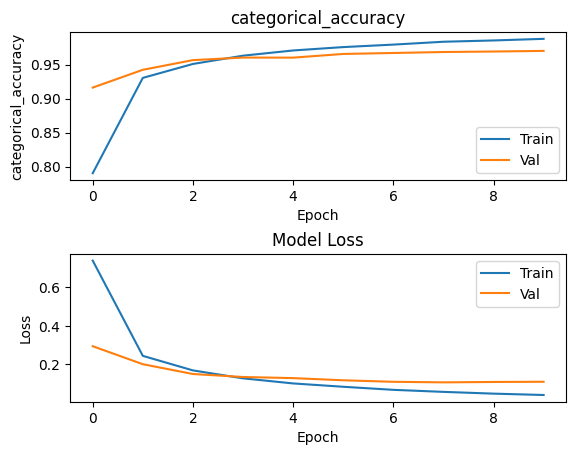

In [ ]:
_, x_train, y_train, x_test, y_test = get_data_model()
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(784,)))
model.add(keras.layers.Dense(100, activation='sigmoid'))
model.add(keras.layers.Dense(100, activation='sigmoid'))
model.add(keras.layers.Dense(100, activation='sigmoid'))
model.add(keras.layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history = model.fit(x_train, y_train, epochs=10, batch_size=60, validation_split=0.2, verbose=1)
plot_history(history, 'categorical_accuracy')

Epoch 1/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - categorical_accuracy: 0.8386 - loss: 0.6318 - val_categorical_accuracy: 0.9349 - val_loss: 0.2157
Epoch 2/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - categorical_accuracy: 0.9379 - loss: 0.2061 - val_categorical_accuracy: 0.9589 - val_loss: 0.1423
Epoch 3/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - categorical_accuracy: 0.9600 - loss: 0.1314 - val_categorical_accuracy: 0.9638 - val_loss: 0.1232
Epoch 4/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - categorical_accuracy: 0.9722 - loss: 0.0906 - val_categorical_accuracy: 0.9697 - val_loss: 0.1023
Epoch 5/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - categorical_accuracy: 0.9775 - loss: 0.0746 - val_categorical_accuracy: 0.9720 - val_loss: 0.0931
Epoch 6/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - categorical_accuracy: 0.9817 - loss: 0.0598 - val_categorical_accuracy: 0.9728 - val_loss: 0.0879
Epoch 7/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - categorical_accuracy: 0.9843 - los

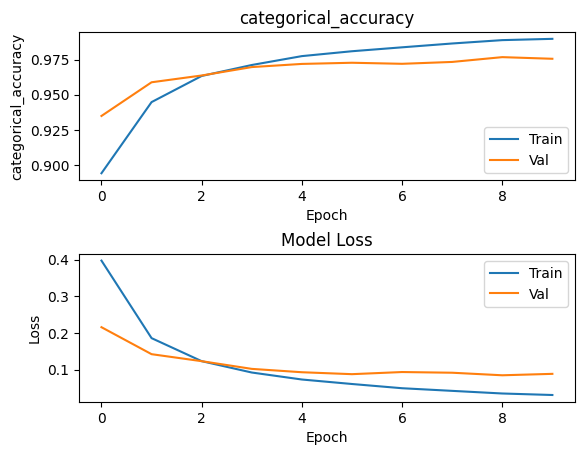

In [ ]:
_, x_train, y_train, x_test, y_test = get_data_model()
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(784,)))
model.add(keras.layers.Dense(100, activation='sigmoid'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(100, activation='sigmoid'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(100, activation='sigmoid'))
model.add(keras.layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history = model.fit(x_train, y_train, epochs=10, batch_size=60, validation_split=0.2, verbose=1)
plot_history(history, 'categorical_accuracy')

In this example, we see how Batch Normalization increased the speed of convergence and helped the model achieve better validation accuracy. Batch Normalization is a key component for training deeper networks such as ResNet variants, which will be introduced in future tutorials. However, it is also sensitive to the batch size and the different statistics used in training (mini-batch statistics) and testing (running mean and std from training) can be problematic in some settings.

## HyperParameters Tuning

### Creating a Validation Set

When training our model, we need to decide the value of several hyperparameters, what regularization techniques we employ, or the loss used to train the model, among others. To decide these values we should not use as guidance the performance in the test set, as it may lead to overfitting to that set, and in turn to an erroneous estimate of the performance of the model in non-seen data. Hence, we use what is called a validation set, which we use to tweak the hyperparameters.

To define a validation split automatically in Keras, we can use two relevant arguments in the `fit` method: `validation_split` and `validation_data`. The argument passed to `validation_split` (0 by default) determines the ratio of the training set for validation purposes. For example,    
```
model.fit(x_train, y_train, ..., validation_split=0.2)
```
uses 20% of `x_train` as validation data.

Using the `validation_split` method the validation data is taken from the last  N indices from your training data as explained in the [documentation](https://keras.io/api/models/model_training_apis/). If we want to fix the split used beforehand, we can use the `validation_data` argument, where we can pass directly the split of data we want to use as validation in the form of a tuple `(data, labels)`.

In these tutorials we mainly use the official test sets of several standard datasets as the input to `validation_data`. The reason we use the given test sets as validation data for the tutorials is that is an easy way to make sure that we all work with the same split and report results using the same data. However, in a proper machine learning setup, your validation set should be separate from the test set, so you can tune the model/parameters on the validation set and then check the final performance in the test set.

### Early Stopping

We now know how to define a validation set and how to use it during the training process. An important step now is how to retrieve the model with the highest validation performance during training. Usually, you keep the model with the highest validation accuracy as your final model, and then, ideally, you would test this final model using an independent test set.
However, validation accuracy fluctuates between epochs, and may actually decrease after a few epochs due to overfitting. Hence, we would like to save the model with the best validation performance.

We already mentioned how to do save the best performing model in the introductory Keras tutorial, but let's explain it again now that we know how to define a validation split. By default, Keras returns the last model after training $N$ epochs. We can instead choose to retrieve the model with the best validation performance by using the [`EarlyStopping`](https://keras.io/api/callbacks/early_stopping/) callback. EarlyStopping monitors a metric (e.g. `val_categorical_accuracy`) and after a few epochs where that metric has not improved (`patience` variable) the training process stops. Finally, if `restore_best_weights` is set to `True`, the weights from the best performing model in the defined metric are restored. Let's see an example.

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', min_delta=0, patience=4, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
_, x_train, y_train, x_test, y_test = get_data_model()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.fit(x_train, y_train, epochs=20, batch_size=32, verbose=1, validation_data=(x_test, y_test), callbacks=[early_stop])

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - categorical_accuracy: 0.9799 - loss: 0.0636 - val_categorical_accuracy: 0.9782 - val_loss: 0.0774
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - categorical_accuracy: 0.9842 - loss: 0.0520 - val_categorical_accuracy: 0.9769 - val_loss: 0.0797
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - categorical_accuracy: 0.9845 - loss: 0.0457 - val_categorical_accuracy: 0.9792 - val_loss: 0.0745
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - categorical_accuracy: 0.9870 - loss: 0.0390 - val_categorical_accuracy: 0.9770 - val_loss: 0.0780
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - categorical_accuracy: 0.9883 - loss: 0.0351 - val_categorical_accuracy: 0.9783 - val_loss: 0.0751
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - categorical_accuracy: 0.9895 - loss: 0.0320 - val_categorical_accuracy: 0.9760 - val_loss: 0.0814
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - categorical_accuracy

We see how the training process stopped after failing to improve `val_categorical_accuracy` during the number of epochs set by `patience. We now check that the performance of the saved model is the same as the obtained in the best epoch in terms of validation accuracy.

In [ ]:
model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - categorical_accuracy: 0.9750 - loss: 0.0896


[0.07445858418941498, 0.979200005531311]

### Learning Rate

One of the most important parameters to tweak is the learning rate, which controls the update step performed during the backpropagation. Keras provides two callbacks that allow us to modify the learning rate during training. One is `LearningRateScheduler`, which allows us to define a rule to vary the learning rate depending on the epoch. For example, using the `lr_scheduler` function (found [here](https://stackoverflow.com/questions/39779710/setting-up-a-learningratescheduler-in-keras)), we can modify the loss function so that every 3 epochs is multiplied by 0.1.

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - categorical_accuracy: 0.8973 - loss: 0.3417 - val_categorical_accuracy: 0.9646 - val_loss: 0.1178 - learning_rate: 0.0010
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - categorical_accuracy: 0.9746 - loss: 0.0838 - val_categorical_accuracy: 0.9732 - val_loss: 0.0913 - learning_rate: 0.0010
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - categorical_accuracy: 0.9812 - loss: 0.0573 - val_categorical_accuracy: 0.9724 - val_loss: 0.1020 - learning_rate: 0.0010
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - categorical_accuracy: 0.9918 - loss: 0.0258 - val_categorical_accuracy: 0.9817 - val_loss: 0.0684 - learning_rate: 1.0000e-04
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - categorical_accuracy: 0.9968 - loss: 0.0116 - val_categorical_accuracy: 0.9819 - val_loss: 0.0713 - learning_rate: 1.0000e-04
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - categorical_accuracy: 0.9987 - loss: 0.0062 - 

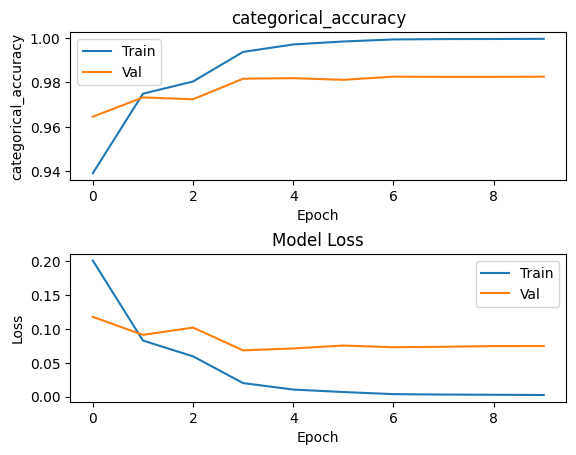

In [ ]:
def lr_scheduler(epoch, lr):
    decay_rate = 0.1
    decay_step = 3
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

lrate = keras.callbacks.LearningRateScheduler(lr_scheduler)
model, x_train, y_train, x_test, y_test = get_data_model()
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])
initial_lr = tf.keras.backend.get_value(model.optimizer.learning_rate)
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[lrate])
print('Initial Learning Rate: {:.4f}'.format(initial_lr))
print('Final Learning Rate: {:.10f}'.format(tf.keras.backend.get_value(model.optimizer.learning_rate)))
plot_history(history, 'categorical_accuracy')

Let's plot the progress of the learning rate in each epoch to check how the learning rate is decreased every three epochs as we defined in `lr_scheduler`.

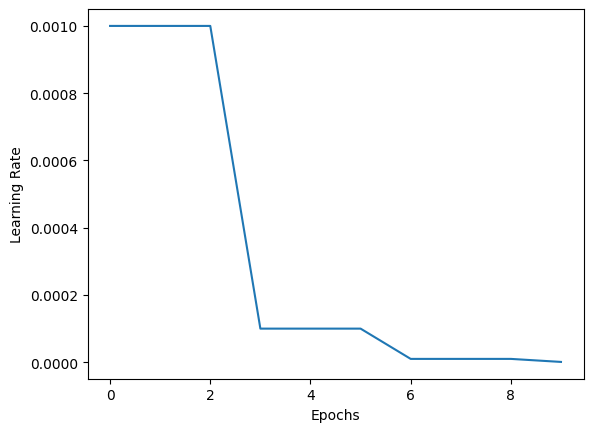

In [ ]:
learning_rate = history.history['learning_rate']
plt.plot(range(0, len(learning_rate)), learning_rate)
plt.ylabel('Learning Rate')
plt.xlabel('Epochs')
plt.show()

Another callback provided is `ReduceLROnPlateau`, which reduces the learning rate whenever a given metric has stopped improving. There are 5 important arguments:

 * `monitor`: we specify the metric we want to track
 * `patience`: number of epochs without improvement before reducing lr
 * `factor`: the new learning rate will be `new_lr = lr * factor`
 * `min_lr`: sets the minimum lr
 * `min_delta`: margin to define when the metric has stopped improving


Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - categorical_accuracy: 0.8957 - loss: 0.3358 - val_categorical_accuracy: 0.9621 - val_loss: 0.1249 - learning_rate: 0.0010
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - categorical_accuracy: 0.9732 - loss: 0.0865 - val_categorical_accuracy: 0.9639 - val_loss: 0.1167 - learning_rate: 0.0010
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - categorical_accuracy: 0.9901 - loss: 0.0343 - val_categorical_accuracy: 0.9797 - val_loss: 0.0694 - learning_rate: 2.0000e-04
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - categorical_accuracy: 0.9956 - loss: 0.0156 - val_categorical_accuracy: 0.9816 - val_loss: 0.0703 - learning_rate: 2.0000e-04
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - categorical_accuracy: 0.9978 - loss: 0.0095 - val_categorical_accuracy: 0.9819 - val_loss: 0.0675 - learning_rate: 4.0000e-05
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - categorical_accuracy: 0.9989 - loss: 0.005

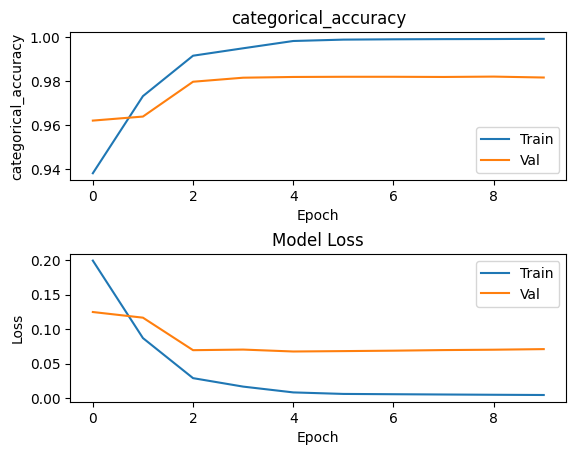

In [ ]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=1, min_lr=0.00001, min_delta = 0.01)
model, x_train, y_train, x_test, y_test = get_data_model()
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])
initial_lr = tf.keras.backend.get_value(model.optimizer.learning_rate)
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[reduce_lr])
print('Initial Learning Rate: {:.4f}'.format(initial_lr))
print('Final Learning Rate: {:.10f}'.format(tf.keras.backend.get_value(model.optimizer.learning_rate)))
plot_history(history, 'categorical_accuracy')

Again, we check how the learning rate has changed. You can check that the learning has indeed decreased when the `val_loss` has not improved by more than 0.01 until it reached the `min_lr` value.

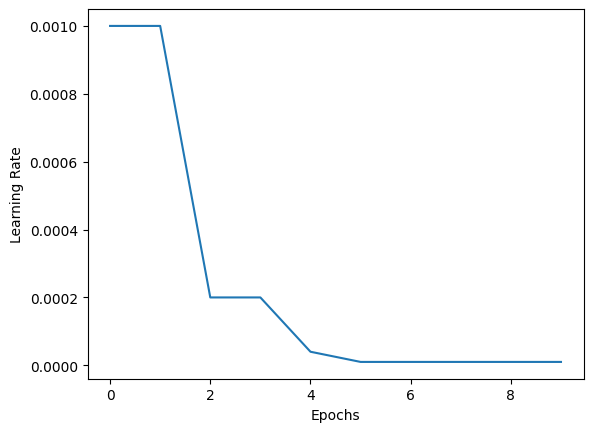

In [ ]:
learning_rate = history.history['learning_rate']
plt.plot(range(0, len(learning_rate)), learning_rate)
plt.ylabel('Learning Rate')
plt.xlabel('Epochs')
plt.show()

## Data augmentation
Deep learning models are data-hungry, tend to overfit with small training sets and its performance benefit from large training sets. A way to synthetically create more data is using data augmentation. Data augmentation aims to modify the training examples by applying transformations to the input data. Now, we will show some examples of data augmentation for images.

### Images
Data augmentation techniques such as rotation, scaling or cropping are usually applied in deep learning pipelines for vision applications. The idea is to take as input an image, apply a transformation to it, and then use it for training.

Keras allows us to perform data augmentation using ImageDataGenerator, which you may see in some other examples online, however by using the preprocessing module we can perform the augmentation directly on the GPU, making it quite faster in the Colabs notebook. The available transformations are listed [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing). The preprocessing module can be imported by doing:




We first define a function `plot_data_augmentation` that we will use to show some augmented examples.



In [ ]:
def plot_data_augmentation(augmentation = None):
  (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
  # A generator that allows us to use flow to output some examples
  data_gen = keras.preprocessing.image.ImageDataGenerator()
  for X_batch, y_batch in data_gen.flow(np.expand_dims(x_train, -1), y_train, batch_size=5, shuffle=False):
    if augmentation is not None:
        X_batch = augmentation(X_batch).numpy()
    for i in range(0, 5):
      plt.subplot(150 + 1 + i)
      plt.imshow(X_batch[i, :].reshape(28, 28), cmap=plt.get_cmap('gray'))
    # show the plot
    plt.show()
    break

We will now visualize some of the transformations available in this preprocessing module. First, we plot some images without any transformations applied for comparison.

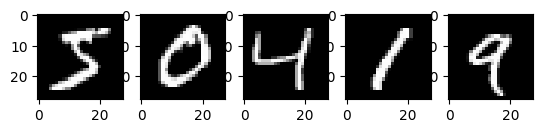

In [ ]:
plot_data_augmentation()

### Rotation
A standard transformation is to rotate the image. We can do so by using `preprocessing.RandomRotation` ([documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomRotation)) with a factor that controls the range of the random rotations. For example, `0.15`rotates the image randomly between `[-0.15*2pi, 0.15*2pi]`

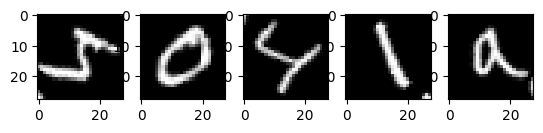

In [ ]:
# We first define the transformation we want to apply
plot_data_augmentation(keras.layers.RandomRotation(0.15))

### Shift

We can define a maximum range of both horizontal (`width_factor`) and vertical (`height_factor`) shift using `preprocessing.RandomTranslation`([documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomTranslation)).

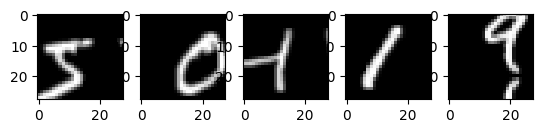

In [ ]:
data_augmentation = keras.layers.RandomTranslation(
    height_factor=0.3, width_factor=0.3, fill_mode='reflect',
    interpolation='bilinear'
)
plot_data_augmentation(data_augmentation)

### Zooming
Zooming into the image can be done with `preprocessing.RandomZoom` ([documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomZoom)). You can define a height factor, that limits the range of height zooming, and a width factor, which similarly limits the range of width zooming.

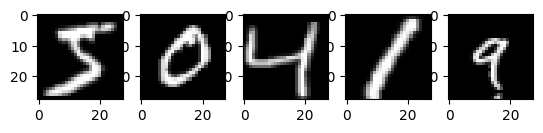

In [ ]:
augmentation_gen = keras.layers.RandomZoom(height_factor=0.4)
plot_data_augmentation(augmentation_gen)

### Flip

We can define either horizontal flip (`horizontal`), vertical (`vertical`) or both (`horizontal_and_vertical`) using `preprocessing.RandomFlip` ([documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomFlip)).  Horizontal flip is one of the most usual augmentations in images.

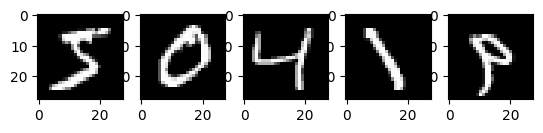

In [ ]:
augmentation_gen = keras.layers.RandomFlip('horizontal')
plot_data_augmentation(augmentation_gen)

### Data Normalization
Data normalization is usually applied in deep learning pipelines. A typical data normalization applied is data standardization, where we transform the input data to have `mean=0` and `std=1`. When you have multiple features coming from different distributions and different scales, normalization makes all of the features have a similar distribution, which avoids biasing the model towards using the features with larger values.

In images, the range of values is already in the same scale of [0-255], but normalizing the range of values to [0-1] can help us avoid starting training in the saturation regions of some activations, such as a sigmoid, where values of large magnitude will fall into the flat region of the activation. Data centering (mean=0) can also useful in some settings because the weight initializers used (e.g. Xavier) are derived following a ``mean=0`` assumption about the data distribution, but probably a model trained with [0-1] will usually converge too.

To perform normalization, we can also use the preprocessing module. In the following example we can see how using `preprocessing.Normalization()` makes our data have `mean=0` and `standard_deviation=1`. Contrary to the other transformations we showed, before normalizing the data we need to use `adapt(train_data)` to compute the mean and standard deviation of the whole training set. The mean and standard deviation computed will then be saved and applied to standardize the individual images.

In [ ]:
normalization = keras.layers.Normalization()
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1)
normalization.adapt(x_train)
# We show the mean and std of the training set
# before and after normalization
print('Normalized mean/std', normalization(x_train).numpy().mean(), normalization(x_train).numpy().std())
print('Original mean/std', x_train.mean(), x_train.std())

Normalized mean/std 2.3430383e-08 0.99999934
Original mean/std 33.318421449829934 78.56748998339798


When using any kind of data normalization, it is important to note that we need to apply the same transformation to the test data for our model to work properly. In the given example we can use the statistics computed from the training data to standardize the test data:

In [ ]:
print('Normalized mean/std', normalization(x_test).numpy().mean(), normalization(x_test).numpy().std())
print('Original mean/std', x_test.mean(), x_test.std())

Normalized mean/std 0.006017815 1.0077
Original mean/std 33.791224489795916 79.17246322228644


### Combining transformations
We have shown how some of the individual data transformations used in data augmentation work. Now we want to show how we can combine all the transformations and how to integrate them in a training pipeline. To do so, we can form a Sequential layer with all of the transformations and add it to the model.

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# We normalize the data first
norm_layer = keras.layers.Normalization()
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)
norm_layer.adapt(x_train)
x_train = norm_layer(x_train)
x_test = norm_layer(x_test)

# We define our data augmentation pipeline
data_augmentation = keras.models.Sequential([
    keras.layers.RandomFlip("vertical"),
    keras.layers.RandomRotation(0.6)
])
y_train_class = keras.utils.to_categorical(y_train, 10)
y_test_class = keras.utils.to_categorical(y_test, 10)
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(28,28,1)))
model.add(data_augmentation)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.fit(x_train, y_train_class,  epochs=3, validation_data=(x_test,y_test_class))

Epoch 1/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - categorical_accuracy: 0.6529 - loss: 1.0350 - val_categorical_accuracy: 0.8179 - val_loss: 0.5683
Epoch 2/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - categorical_accuracy: 0.8403 - loss: 0.4916 - val_categorical_accuracy: 0.8465 - val_loss: 0.4867
Epoch 3/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - categorical_accuracy: 0.8673 - loss: 0.4144 - val_categorical_accuracy: 0.8625 - val_loss: 0.4237


We see how the data augmentation process is integrated into the model as it was an extra initial layer. At inference time, most of the preprocessing layers are not active.

In these examples, we showed practical examples of data augmentation for images. However, other modalities, such as text or audio can also benefit from data augmentation.

Keep in mind that applying a data augmentation strategy that is too aggressive may actually harm the performance in the test set, e.g., applying extreme zooms not likely to be present in the dataset or strong contrast shifts.

# Coursework

### Task 1: Tuning a Classification Model
In a machine learning problem, and especially when using a deep learning approach, finding the right set of hyperparameters, the right data augmentation strategy, or a good regularization method can make the difference between a model that performs poorly and a model with great accuracy.

For this exercise, you will be training a CNN to perform classification in CIFAR-10 (we use the official test set, which is why the variables are called `x_test` and `y_test`, as our validation set) and will analyze the impact of some of the most important elements presented in this tutorial.

Use the CNN we give in the code below, along with the given optimizer and number of training epochs as the default setting. Only modify the given CNN architecture to add Dropout or Batch Normalization layers when explicitly stated. Use 40 epochs to plot all of your curves. However, you can train for more epochs to find your best validation performance if your network has not finished training in those 40 epochs.

**Report:**
*  First, train the given default model without any data augmentation. Then define two data augmentation strategies (one more aggressive than the other) and train the model with data augmentation. Clearly state the two augmentation strategies you apply (i.e., the specific transformations). Discuss the training and validation loss curves for the two data augmentation strategies along with the original run without data augmentation. Attach in the appendix those training and validation curves. Report in a table the best validation accuracy obtained for the three runs (no data augmentation, data augmentation 1, data augmentation 2).

*  Without using any data augmentation, analyze the effect of using Dropout in the model. Carry out the same analysis for Batch Normalization. Finally, combine both. Report in the same table as in the data augmentation task the best validation accuracy for each of the three settings (baseline + Dropout, baseline + Batch Normalization, baseline + Batch Normalization + Dropout). The performance will vary depending on where the Dropout layers and Batch Normalization layers, so state clearly where you added the layers, and what rate you used for the Dropout layers. Discuss the results.

* Using the default model/hyperparameters and no data augmentation, report the best validation accuracy when using `zeros` for the kernel initialization. Report the performance in the same table as in the dropout/batch normalization/data augmentation tasks. Discuss the results that you obtained.

*  Using the default model and no data augmentation, change the optimizer to SGD and train it with learning rates of `3e-3`, `1e-3` and `3e-4`. Report in a figure the training and validation loss for the three learning rate values and discuss the figure.

### default with out augmentation

In [ ]:
#train the given default model without any data augmentation
# load the data
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

print('Image shape: {0}'.format(X_train.shape[1:]))
print('Total number of training samples: {0}'.format(X_train.shape[0]))
print('Total number of validation samples: {0}'.format(X_test.shape[0]))

X_train = X_train.reshape(-1,32,32,3)

## Normalization block
norm_layer = keras.layers.Normalization()
norm_layer.adapt(X_train)
X_train_n = norm_layer(X_train)
X_test_n = norm_layer(X_test)

# You can modify the data_augmentation variable below to add your
# data augmentation pipeline.
# By default we do not apply any augmentation (RandomZoom(0) is equivalent
# to not performing any augmentation)
data_augmentation = keras.models.Sequential(
    [
        keras.layers.RandomZoom(0)
    ]
)
# We will use glorot_uniform as a initialization by default
initialization = 'glorot_uniform'
# Use the architecture given below, only modify it to add Dropout/BatchNorm
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(32,32,3)))
model.add(data_augmentation)
model.add(keras.layers.Conv2D(32, (3, 3), padding='same', kernel_initializer=initialization))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer=initialization))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer=initialization))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(keras.layers.Conv2D(256, (3, 3), padding='same', kernel_initializer=initialization))
model.add(keras.layers.Activation('relu'))
# As we use global average pooling, we don't need to use Flatten
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Dense(10, kernel_initializer=initialization))
model.add(keras.layers.Activation('softmax'))


Y_train_class = keras.utils.to_categorical(y_train, 10)
Y_test_class = keras.utils.to_categorical(y_test, 10)
# By default use Adam with lr=3e-4. Change it to SGD when asked to
opt = keras.optimizers.Adam(learning_rate=3e-4)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,                          # Stop training after 5 epochs of no improvement
    mode='min',                          # Maximize the validation loss
    restore_best_weights=True            # Restore model weights from the best epoch
)

# Train the model with early stopping
history = model.fit(
    X_train_n, Y_train_class,
    epochs=40,  # Use a larger number of epochs to allow early stopping
    validation_data=(X_test_n, Y_test_class),
    #callbacks=[early_stopping]  # Add early stopping callback
)
# Save the training history to a file
with open('history_m1.pkl', 'wb') as file:
    pickle.dump(history.history, file)
print("Training history saved to history.pkl")

Image shape: (32, 32, 3)
Total number of training samples: 50000
Total number of validation samples: 10000
Epoch 1/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.3454 - loss: 1.7741 - val_accuracy: 0.5032 - val_loss: 1.3686
Epoch 2/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.5573 - loss: 1.2364 - val_accuracy: 0.6296 - val_loss: 1.0618
Epoch 3/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.6338 - loss: 1.0444 - val_accuracy: 0.6598 - val_loss: 0.9741
Epoch 4/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.6760 - loss: 0.9231 - val_accuracy: 0.7020 - val_loss: 0.8739
Epoch 5/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.7064 - loss: 0.8346 - val_accuracy: 0.7169 - val_loss: 0.8159
Epoch 6/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.7390 - loss: 0.7503 - val_accuracy: 0.7300 - val_loss: 0.7630
Epoch 7/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.7662 - loss: 0.6724 - val_accuracy: 0.

### non aggressive data augmentation

In [ ]:
# non aggressive data augmentation
# load the data
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

print('Image shape: {0}'.format(X_train.shape[1:]))
print('Total number of training samples: {0}'.format(X_train.shape[0]))
print('Total number of validation samples: {0}'.format(X_test.shape[0]))

X_train = X_train.reshape(-1,32,32,3)

## Normalization block
norm_layer = keras.layers.Normalization()
norm_layer.adapt(X_train)
X_train_n = norm_layer(X_train)
X_test_n = norm_layer(X_test)

# You can modify the data_augmentation variable below to add your
# data augmentation pipeline.
# By default we do not apply any augmentation (RandomZoom(0) is equivalent
# to not performing any augmentation)
data_augmentation = keras.models.Sequential(
    [
        keras.layers.RandomRotation(0.15),
        keras.layers.RandomZoom(0.1),
        # keras.layers.RandomTranslation( height_factor=0.1, width_factor=0.1, fill_mode='reflect', interpolation='bilinear'),
    ]
)

# We will use glorot_uniform as a initialization by default
initialization = 'glorot_uniform'
# Use the architecture given below, only modify it to add Dropout/BatchNorm
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(32,32,3)))
model.add(data_augmentation)
model.add(keras.layers.Conv2D(32, (3, 3), padding='same', kernel_initializer=initialization))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer=initialization))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer=initialization))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(keras.layers.Conv2D(256, (3, 3), padding='same', kernel_initializer=initialization))
model.add(keras.layers.Activation('relu'))
# As we use global average pooling, we don't need to use Flatten
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Dense(10, kernel_initializer=initialization))
model.add(keras.layers.Activation('softmax'))


Y_train_class = keras.utils.to_categorical(y_train, 10)
Y_test_class = keras.utils.to_categorical(y_test, 10)
# By default use Adam with lr=3e-4. Change it to SGD when asked to
opt = keras.optimizers.Adam(learning_rate=3e-4)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation accuracy
    patience=5,                          # Stop training after 5 epochs of no improvement
    mode='min',                          # Maximize the validation accuracy
    restore_best_weights=True            # Restore model weights from the best epoch
)

# Train the model with early stopping
history = model.fit(
    X_train_n, Y_train_class,
    epochs=40,  # Use a larger number of epochs to allow early stopping
    validation_data=(X_test_n, Y_test_class),
    #callbacks=[early_stopping]  # Add early stopping callback
)

# Save the training history to a file
with open('history_m2.pkl', 'wb') as file:
    pickle.dump(history.history, file)
print("Training history saved to history_m2.pkl")

Image shape: (32, 32, 3)
Total number of training samples: 50000
Total number of validation samples: 10000
Epoch 1/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.3081 - loss: 1.8848 - val_accuracy: 0.4585 - val_loss: 1.5407
Epoch 2/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.4633 - loss: 1.5024 - val_accuracy: 0.5262 - val_loss: 1.3182
Epoch 3/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.5163 - loss: 1.3524 - val_accuracy: 0.5481 - val_loss: 1.2934
Epoch 4/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - accuracy: 0.5471 - loss: 1.2666 - val_accuracy: 0.5648 - val_loss: 1.2292
Epoch 5/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.5750 - loss: 1.1859 - val_accuracy: 0.5802 - val_loss: 1.2421
Epoch 6/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.5986 - loss: 1.1254 - val_accuracy: 0.6375 - val_loss: 1.0390
Epoch 7/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.6228 - loss: 1.0568 - val_accuracy: 0.

### aggressive augmentation

In [ ]:
#aggressive data augmentation
# load the data
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

print('Image shape: {0}'.format(X_train.shape[1:]))
print('Total number of training samples: {0}'.format(X_train.shape[0]))
print('Total number of validation samples: {0}'.format(X_test.shape[0]))

X_train = X_train.reshape(-1,32,32,3)

## Normalization block
norm_layer = keras.layers.Normalization()
norm_layer.adapt(X_train)
X_train_n = norm_layer(X_train)
X_test_n = norm_layer(X_test)

# You can modify the data_augmentation variable below to add your
# data augmentation pipeline.
# By default we do not apply any augmentation (RandomZoom(0) is equivalent
# to not performing any augmentation)
data_augmentation = keras.models.Sequential(
    [
        keras.layers.RandomFlip('horizontal'),
        keras.layers.RandomRotation(0.3),
        keras.layers.RandomZoom(0.3),
        keras.layers.RandomTranslation( height_factor=0.3, width_factor=0.3, fill_mode='reflect', interpolation='bilinear'),
    ]
)

# We will use glorot_uniform as a initialization by default
initialization = 'glorot_uniform'
# Use the architecture given below, only modify it to add Dropout/BatchNorm
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(32,32,3)))
model.add(data_augmentation)
model.add(keras.layers.Conv2D(32, (3, 3), padding='same', kernel_initializer=initialization))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer=initialization))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer=initialization))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(keras.layers.Conv2D(256, (3, 3), padding='same', kernel_initializer=initialization))
model.add(keras.layers.Activation('relu'))
# As we use global average pooling, we don't need to use Flatten
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Dense(10, kernel_initializer=initialization))
model.add(keras.layers.Activation('softmax'))


Y_train_class = keras.utils.to_categorical(y_train, 10)
Y_test_class = keras.utils.to_categorical(y_test, 10)
# By default use Adam with lr=3e-4. Change it to SGD when asked to
opt = keras.optimizers.Adam(learning_rate=3e-4)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation accuracy
    patience=5,                          # Stop training after 5 epochs of no improvement
    mode='min',                          # Maximize the validation accuracy
    restore_best_weights=True            # Restore model weights from the best epoch
)

# Train the model with early stopping
history = model.fit(
    X_train_n, Y_train_class,
    epochs=40,  # Use a larger number of epochs to allow early stopping
    validation_data=(X_test_n, Y_test_class),
    #callbacks=[early_stopping]  # Add early stopping callback
)

# Save the training history to a file
with open('history_m3.pkl', 'wb') as file:
    pickle.dump(history.history, file)
print("Training history saved to history_m3.pkl")

Image shape: (32, 32, 3)
Total number of training samples: 50000
Total number of validation samples: 10000
Epoch 1/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.2364 - loss: 2.0374 - val_accuracy: 0.3236 - val_loss: 1.9416
Epoch 2/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.3433 - loss: 1.8084 - val_accuracy: 0.3751 - val_loss: 1.7570
Epoch 3/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.3844 - loss: 1.7072 - val_accuracy: 0.4263 - val_loss: 1.6111
Epoch 4/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.4070 - loss: 1.6384 - val_accuracy: 0.4470 - val_loss: 1.5376
Epoch 5/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.4341 - loss: 1.5795 - val_accuracy: 0.4610 - val_loss: 1.5289
Epoch 6/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.4497 - loss: 1.5321 - val_accuracy: 0.4914 - val_loss: 1.4283
Epoch 7/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.4701 - loss: 1.4817 - val_accuracy: 0.

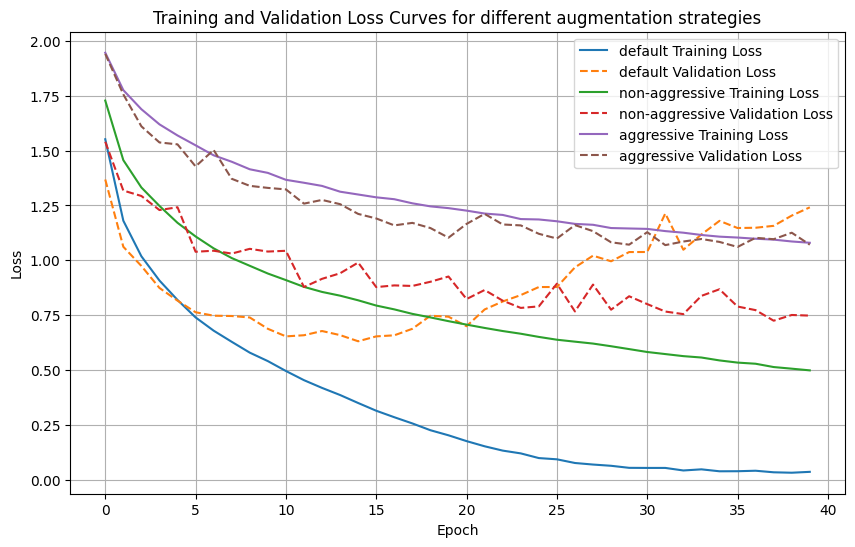


Best Validation Accuracy for Each Run:
+----------------+----------------------------+
| Strategy       |   Best Validation Accuracy |
+================+============================+
| default        |                     0.8003 |
+----------------+----------------------------+
| non-aggressive |                     0.7681 |
+----------------+----------------------------+
| aggressive     |                     0.6409 |
+----------------+----------------------------+


In [ ]:
# List of history files
history_files = ['history_m1.pkl', 'history_m2.pkl', 'history_m3.pkl']
labels = ['default', 'non-aggressive', 'aggressive']

# Dictionary to store loaded histories
histories = {}

# Load histories
for file_name, label in zip(history_files, labels):
    try:
        with open(file_name, 'rb') as file:
            histories[label] = pickle.load(file)
    except FileNotFoundError:
        print(f"File {file_name} not found.")
    except Exception as e:
        print(f"Error loading {file_name}: {e}")

# Plotting the loss curves
plt.figure(figsize=(10, 6))
for label, history in histories.items():
    if 'loss' in history and 'val_loss' in history:
        plt.plot(history['loss'], label=f'{label} Training Loss')
        plt.plot(history['val_loss'], linestyle='--', label=f'{label} Validation Loss')
    else:
        print(f"Loss data not found in {label}")

# Add plot details
plt.title('Training and Validation Loss Curves for different augmentation strategies')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Extract and display the best validation accuracy for each run
results = []
for label, history in histories.items():
    if 'val_accuracy' in history:
        best_val_accuracy = max(history['val_accuracy'])
        results.append([label, best_val_accuracy])
    else:
        print(f"No validation accuracy data found for {label}")

# Display the results in a table
if results:
    print("\nBest Validation Accuracy for Each Run:")
    print(tabulate(results, headers=["Strategy", "Best Validation Accuracy"], tablefmt="grid"))

###

### Drop out

In [ ]:
# drop out
# load the data
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

print('Image shape: {0}'.format(X_train.shape[1:]))
print('Total number of training samples: {0}'.format(X_train.shape[0]))
print('Total number of validation samples: {0}'.format(X_test.shape[0]))

X_train = X_train.reshape(-1,32,32,3)

## Normalization block
norm_layer = keras.layers.Normalization()
norm_layer.adapt(X_train)
X_train_n = norm_layer(X_train)
X_test_n = norm_layer(X_test)

# You can modify the data_augmentation variable below to add your
# data augmentation pipeline.
# By default we do not apply any augmentation (RandomZoom(0) is equivalent
# to not performing any augmentation)
data_augmentation = keras.models.Sequential(
    [
        keras.layers.RandomRotation(0.15),
        keras.layers.RandomZoom(0.1),
        # keras.layers.RandomTranslation( height_factor=0.1, width_factor=0.1, fill_mode='reflect', interpolation='bilinear'),
    ]
)

# We will use glorot_uniform as a initialization by default
initialization = 'glorot_uniform'
# Use the architecture given below, only modify it to add Dropout/BatchNorm
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(32,32,3)))
model.add(data_augmentation)
model.add(keras.layers.Conv2D(32, (3, 3), padding='same', kernel_initializer=initialization))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))


model.add(keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer=initialization))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))


model.add(keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer=initialization))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))


model.add(keras.layers.Conv2D(256, (3, 3), padding='same', kernel_initializer=initialization))
model.add(keras.layers.Activation('relu'))

# As we use global average pooling, we don't need to use Flatten
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Dense(10, kernel_initializer=initialization))
model.add(keras.layers.Dropout((0.2)))
model.add(keras.layers.Activation('softmax'))


Y_train_class = keras.utils.to_categorical(y_train, 10)
Y_test_class = keras.utils.to_categorical(y_test, 10)
# By default use Adam with lr=3e-4. Change it to SGD when asked to
opt = keras.optimizers.Adam(learning_rate=3e-4)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=4,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

# Train the model with early stopping
history = model.fit(
    X_train_n, Y_train_class,
    epochs=40,  # Use a larger number of epochs to allow early stopping
    validation_data=(X_test_n, Y_test_class),
    #callbacks=[early_stopping]  # Add early stopping callback
)

# Save the training history to a file
with open('/content/drive/MyDrive/DeepLearning/03/history_m4.pkl', 'wb') as file:
    pickle.dump(history.history, file)
print("Training history saved to history_m4.pkl")

Image shape: (32, 32, 3)
Total number of training samples: 50000
Total number of validation samples: 10000
Epoch 1/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.2694 - loss: 1.9950 - val_accuracy: 0.4214 - val_loss: 1.5660
Epoch 2/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.4058 - loss: 1.6566 - val_accuracy: 0.5156 - val_loss: 1.3546
Epoch 3/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.4517 - loss: 1.5344 - val_accuracy: 0.5193 - val_loss: 1.3404
Epoch 4/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.4779 - loss: 1.4598 - val_accuracy: 0.5744 - val_loss: 1.2092
Epoch 5/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.4966 - loss: 1.3990 - val_accuracy: 0.5906 - val_loss: 1.1558
Epoch 6/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.5202 - loss: 1.3446 - val_accuracy: 0.6136 - val_loss: 1.1113
Epoch 7/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.5357 - loss: 1.2929 - val_accuracy: 0.

In [ ]:
# drop out
# load the data
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

print('Image shape: {0}'.format(X_train.shape[1:]))
print('Total number of training samples: {0}'.format(X_train.shape[0]))
print('Total number of validation samples: {0}'.format(X_test.shape[0]))

X_train = X_train.reshape(-1,32,32,3)

## Normalization block
norm_layer = keras.layers.Normalization()
norm_layer.adapt(X_train)
X_train_n = norm_layer(X_train)
X_test_n = norm_layer(X_test)

# You can modify the data_augmentation variable below to add your
# data augmentation pipeline.
# By default we do not apply any augmentation (RandomZoom(0) is equivalent
# to not performing any augmentation)
data_augmentation = keras.models.Sequential(
    [
        keras.layers.RandomRotation(0.15),
        keras.layers.RandomZoom(0.1),
        # keras.layers.RandomTranslation( height_factor=0.1, width_factor=0.1, fill_mode='reflect', interpolation='bilinear'),
    ]
)

# We will use glorot_uniform as a initialization by default
initialization = 'glorot_uniform'
# Use the architecture given below, only modify it to add Dropout/BatchNorm
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(32,32,3)))
model.add(data_augmentation)
model.add(keras.layers.Conv2D(32, (3, 3), padding='same', kernel_initializer=initialization))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))


model.add(keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer=initialization))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))


model.add(keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer=initialization))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))


model.add(keras.layers.Conv2D(256, (3, 3), padding='same', kernel_initializer=initialization))
model.add(keras.layers.Activation('relu'))


# As we use global average pooling, we don't need to use Flatten
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.1))  # Dropout in deeper layers
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(10, kernel_initializer=initialization))
model.add(keras.layers.Activation('softmax'))


Y_train_class = keras.utils.to_categorical(y_train, 10)
Y_test_class = keras.utils.to_categorical(y_test, 10)
# By default use Adam with lr=3e-4. Change it to SGD when asked to
opt = keras.optimizers.Adam(learning_rate=3e-4)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=4,
    verbose=0,
    mode='max',
    baseline=None,
    restore_best_weights=True
)

# Train the model with early stopping
history = model.fit(
    X_train_n, Y_train_class,
    epochs=100,  # Use a larger number of epochs to allow early stopping
    validation_data=(X_test_n, Y_test_class),
    callbacks=[early_stopping]  # Add early stopping callback
)

# Save the training history to a file
with open('/content/drive/MyDrive/DeepLearning/03/history_m11.pkl', 'wb') as file:
    pickle.dump(history.history, file)
print("Training history saved to history_m11.pkl")

Image shape: (32, 32, 3)
Total number of training samples: 50000
Total number of validation samples: 10000
Epoch 1/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.2741 - loss: 1.9501 - val_accuracy: 0.4265 - val_loss: 1.5506
Epoch 2/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.4496 - loss: 1.5156 - val_accuracy: 0.5195 - val_loss: 1.3416
Epoch 3/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.5049 - loss: 1.3617 - val_accuracy: 0.5598 - val_loss: 1.2337
Epoch 4/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.5486 - loss: 1.2523 - val_accuracy: 0.5946 - val_loss: 1.1280
Epoch 5/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.5798 - loss: 1.1676 - val_accuracy: 0.6000 - val_loss: 1.1279
Epoch 6/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.6095 - loss: 1.0895 - val_accuracy: 0.6037 - val_loss: 1.1379
Epoch 7/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.6302 - loss: 1.0395 - val

### batch normalization

In [ ]:
# load the data
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

print('Image shape: {0}'.format(X_train.shape[1:]))
print('Total number of training samples: {0}'.format(X_train.shape[0]))
print('Total number of validation samples: {0}'.format(X_test.shape[0]))

X_train = X_train.reshape(-1,32,32,3)

## Normalization block
norm_layer = keras.layers.Normalization()
norm_layer.adapt(X_train)
X_train_n = norm_layer(X_train)
X_test_n = norm_layer(X_test)

# You can modify the data_augmentation variable below to add your
# data augmentation pipeline.
# By default we do not apply any augmentation (RandomZoom(0) is equivalent
# to not performing any augmentation)
data_augmentation = keras.models.Sequential(
    [
        keras.layers.RandomRotation(0.15),
        keras.layers.RandomZoom(0.1),
        # keras.layers.RandomTranslation( height_factor=0.1, width_factor=0.1, fill_mode='reflect', interpolation='bilinear'),
    ]
)

# We will use glorot_uniform as a initialization by default
initialization = 'glorot_uniform'
# Use the architecture given below, only modify it to add Dropout/BatchNorm
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(32,32,3)))
model.add(data_augmentation)
model.add(keras.layers.Conv2D(32, (3, 3), padding='same', kernel_initializer=initialization))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))


model.add(keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer=initialization))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))


model.add(keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer=initialization))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))


model.add(keras.layers.Conv2D(256, (3, 3), padding='same', kernel_initializer=initialization))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))


# As we use global average pooling, we don't need to use Flatten
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Dense(10, kernel_initializer=initialization))
model.add(keras.layers.Activation('softmax'))


Y_train_class = keras.utils.to_categorical(y_train, 10)
Y_test_class = keras.utils.to_categorical(y_test, 10)
# By default use Adam with lr=3e-4. Change it to SGD when asked to
opt = keras.optimizers.Adam(learning_rate=3e-4)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation accuracy
    patience=5,                          # Stop training after 5 epochs of no improvement
    mode='min',                          # Maximize the validation accuracy
    restore_best_weights=True            # Restore model weights from the best epoch
)

# Train the model with early stopping
history = model.fit(
    X_train_n, Y_train_class,
    epochs=40,  # Use a larger number of epochs to allow early stopping
    validation_data=(X_test_n, Y_test_class),
    #callbacks=[early_stopping]  # Add early stopping callback
)

# Save the training history to a file
with open('/content/drive/MyDrive/DeepLearning/03/history_m5.pkl', 'wb') as file:
    pickle.dump(history.history, file)
print("Training history saved to history_m5.pkl")

Image shape: (32, 32, 3)
Total number of training samples: 50000
Total number of validation samples: 10000
Epoch 1/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.3886 - loss: 1.6849 - val_accuracy: 0.5156 - val_loss: 1.3819
Epoch 2/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.5454 - loss: 1.2789 - val_accuracy: 0.5646 - val_loss: 1.2270
Epoch 3/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.5945 - loss: 1.1475 - val_accuracy: 0.6043 - val_loss: 1.1296
Epoch 4/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.6244 - loss: 1.0590 - val_accuracy: 0.6261 - val_loss: 1.0890
Epoch 5/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.6504 - loss: 0.9878 - val_accuracy: 0.6424 - val_loss: 1.0463
Epoch 6/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.6651 - loss: 0.9584 - val_accuracy: 0.6364 - val_loss: 1.0971
Epoch 7/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.6858 - loss: 0.9043 - val_accuracy: 

### dropout + batch

In [ ]:
# load the data
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

print('Image shape: {0}'.format(X_train.shape[1:]))
print('Total number of training samples: {0}'.format(X_train.shape[0]))
print('Total number of validation samples: {0}'.format(X_test.shape[0]))

X_train = X_train.reshape(-1,32,32,3)

## Normalization block
norm_layer = keras.layers.Normalization()
norm_layer.adapt(X_train)
X_train_n = norm_layer(X_train)
X_test_n = norm_layer(X_test)

# You can modify the data_augmentation variable below to add your
# data augmentation pipeline.
# By default we do not apply any augmentation (RandomZoom(0) is equivalent
# to not performing any augmentation)
data_augmentation = keras.models.Sequential(
    [
        keras.layers.RandomRotation(0.15),
        keras.layers.RandomZoom(0.1),
        # keras.layers.RandomTranslation( height_factor=0.1, width_factor=0.1, fill_mode='reflect', interpolation='bilinear'),
    ]
)

# We will use glorot_uniform as a initialization by default
initialization = 'glorot_uniform'
# Use the architecture given below, only modify it to add Dropout/BatchNorm
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(32,32,3)))
model.add(data_augmentation)
model.add(keras.layers.Conv2D(32, (3, 3), padding='same', kernel_initializer=initialization))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))


model.add(keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer=initialization))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))


model.add(keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer=initialization))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))


model.add(keras.layers.Conv2D(256, (3, 3), padding='same', kernel_initializer=initialization))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))

# As we use global average pooling, we don't need to use Flatten
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Dense(10, kernel_initializer=initialization))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Activation('softmax'))


Y_train_class = keras.utils.to_categorical(y_train, 10)
Y_test_class = keras.utils.to_categorical(y_test, 10)
# By default use Adam with lr=3e-4. Change it to SGD when asked to
opt = keras.optimizers.Adam(learning_rate=3e-4)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation accuracy
    patience=5,                          # Stop training after 5 epochs of no improvement
    mode='min',                          # Maximize the validation accuracy
    restore_best_weights=True            # Restore model weights from the best epoch
)

# Train the model with early stopping
history = model.fit(
    X_train_n, Y_train_class,
    epochs=40,  # Use a larger number of epochs to allow early stopping
    validation_data=(X_test_n, Y_test_class),
    #callbacks=[early_stopping]  # Add early stopping callback
)

# Save the training history to a file
with open('/content/drive/MyDrive/DeepLearning/03/history_m6.pkl', 'wb') as file:
    pickle.dump(history.history, file)
print("Training history saved to history_m5.pkl")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Image shape: (32, 32, 3)
Total number of training samples: 50000
Total number of validation samples: 10000
Epoch 1/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - accuracy: 0.3589 - loss: 1.7853 - val_accuracy: 0.4967 - val_loss: 1.3592
Epoch 2/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 37s 13ms/step - accuracy: 0.4754 - loss: 1.4834 - val_accuracy: 0.5589 - val_loss: 1.2328
Epoch 3/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.5079 - loss: 1.3847 - val_accuracy: 0.5645 - val_loss: 1.2940
Epoch 4/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.5303 - loss: 1.3230 - val_accuracy: 0.5618 - val_loss: 1.2262
Epoch 5/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.5502 - loss: 1.2573 - val_accuracy: 0.5598 - val_loss: 1.3286
Epoch 6/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.5674 - loss: 1.2162 - val_accuracy: 0.6351 - val_loss: 1.0460
Epoch 7/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 12

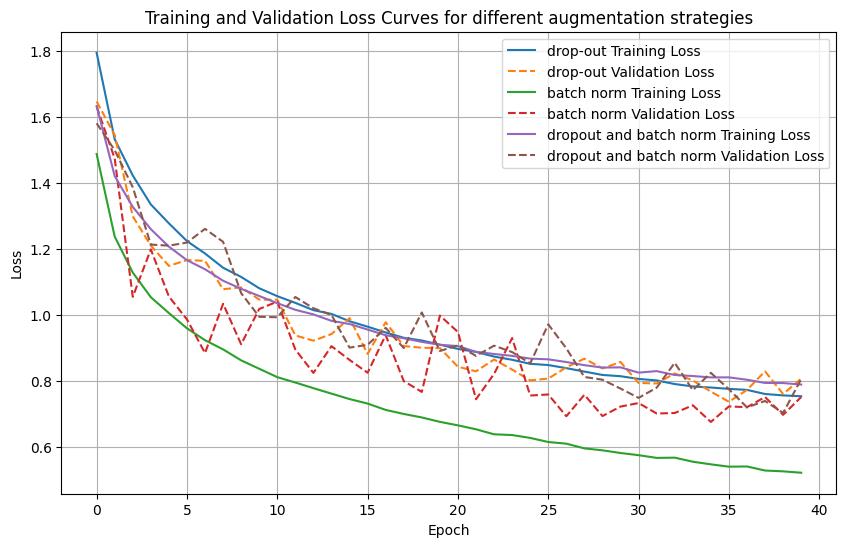


Best Validation Accuracy for Each Run:
+------------------------+----------------------------+
| Strategy               |   Best Validation Accuracy |
+========================+============================+
| drop-out               |                     0.7461 |
+------------------------+----------------------------+
| batch norm             |                     0.7746 |
+------------------------+----------------------------+
| dropout and batch norm |                     0.7537 |
+------------------------+----------------------------+


In [ ]:
# List of history files
history_files = [
    '/content/drive/MyDrive/DeepLearning/03/history_m4.pkl',
    '/content/drive/MyDrive/DeepLearning/03/history_m5.pkl',
    '/content/drive/MyDrive/DeepLearning/03/history_m6.pkl'
]
labels = ['drop-out','batch norm','dropout and batch norm']

# Dictionary to store loaded histories
histories = {}

# Load histories
for file_name, label in zip(history_files, labels):
    try:
        with open(file_name, 'rb') as file:
            histories[label] = pickle.load(file)
    except FileNotFoundError:
        print(f"File {file_name} not found.")
    except Exception as e:
        print(f"Error loading {file_name}: {e}")

# Plotting the loss curves
plt.figure(figsize=(10, 6))
for label, history in histories.items():
    if 'loss' in history and 'val_loss' in history:
        plt.plot(history['loss'], label=f'{label} Training Loss')
        plt.plot(history['val_loss'], linestyle='--', label=f'{label} Validation Loss')
    else:
        print(f"Loss data not found in {label}")

# Add plot details
plt.title('Training and Validation Loss Curves for different augmentation strategies')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Extract and display the best validation accuracy for each run
results = []
for label, history in histories.items():
    if 'val_accuracy' in history:
        best_val_accuracy = max(history['val_accuracy'])
        results.append([label, best_val_accuracy])
    else:
        print(f"No validation accuracy data found for {label}")

# Display the results in a table
if results:
    print("\nBest Validation Accuracy for Each Run:")
    print(tabulate(results, headers=["Strategy", "Best Validation Accuracy"], tablefmt="grid"))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### zero initializer

In [ ]:
from keras import initializers
import pickle
import keras

# Load the data
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

# Normalization block
norm_layer = keras.layers.Normalization()
norm_layer.adapt(X_train)
X_train_n = norm_layer(X_train)
X_test_n = norm_layer(X_test)

# Use Zeros initialization for kernel weights
initialization = keras.initializers.Zeros()  # Kernel initialized to zeros

# Define the model
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(32, 32, 3)))

# First Conv Block
model.add(keras.layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='random_normal',
                bias_initializer='zeros'))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

# Second Conv Block
model.add(keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='random_normal',
                bias_initializer='zeros'))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

# Third Conv Block
model.add(keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='random_normal',
                bias_initializer='zeros'))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

# Fourth Conv Block
model.add(keras.layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='random_normal',
                bias_initializer='zeros'))
model.add(keras.layers.Activation('relu'))

# Global Average Pooling
model.add(keras.layers.GlobalAveragePooling2D())

# Dense Layer
model.add(keras.layers.Dense(10, kernel_initializer='random_normal',
                bias_initializer='zeros'))
model.add(keras.layers.Activation('softmax'))

# Prepare the data
Y_train_class = keras.utils.to_categorical(y_train, 10)
Y_test_class = keras.utils.to_categorical(y_test, 10)

# Compile the model
opt = keras.optimizers.Adam(learning_rate=3e-4)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_n, Y_train_class,
    epochs=40,  # Maximum number of epochs
    validation_data=(X_test_n, Y_test_class),
    verbose=1
)

# Extract the best validation accuracy
best_val_acc = max(history.history['val_accuracy'])
print(f"Best Validation Accuracy with Zero Initialization: {best_val_acc:.2%}")

# Save the training history to a file
with open('/content/drive/MyDrive/DeepLearning/03/history_m7.pkl', 'wb') as file:
    pickle.dump(history.history, file)
print("Training history saved to history_m7.pkl")


Epoch 1/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.3402 - loss: 1.7874 - val_accuracy: 0.5323 - val_loss: 1.3041
Epoch 2/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.5424 - loss: 1.2726 - val_accuracy: 0.6018 - val_loss: 1.1160
Epoch 3/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6126 - loss: 1.0905 - val_accuracy: 0.6394 - val_loss: 1.0221
Epoch 4/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.6597 - loss: 0.9673 - val_accuracy: 0.6616 - val_loss: 0.9494
Epoch 5/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.6928 - loss: 0.8771 - val_accuracy: 0.6887 - val_loss: 0.8778
Epoch 6/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.7131 - loss: 0.8197 - val_accuracy: 0.7015 - val_loss: 0.8541
Epoch 7/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7393 - loss: 0.7501 - val_accuracy: 0.7215 - val_loss: 0.7927
Epoch 8/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.7592 - loss: 0.

### optimizer

In [ ]:
from keras import optimizers
import pickle

# Load the data
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

print('Image shape: {0}'.format(X_train.shape[1:]))
print('Total number of training samples: {0}'.format(X_train.shape[0]))
print('Total number of validation samples: {0}'.format(X_test.shape[0]))

X_train = X_train.reshape(-1, 32, 32, 3)

# Normalization block
norm_layer = keras.layers.Normalization()
norm_layer.adapt(X_train)
X_train_n = norm_layer(X_train)
X_test_n = norm_layer(X_test)

# Data Augmentation
data_augmentation = keras.models.Sequential([
    keras.layers.RandomZoom(0)  # No actual augmentation here
])

# Initialize model with the same structure
initialization = 'glorot_uniform'
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(32, 32, 3)))
model.add(data_augmentation)

# First Conv Block
model.add(keras.layers.Conv2D(32, (3, 3), padding='same', kernel_initializer=initialization))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

# Second Conv Block
model.add(keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer=initialization))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

# Third Conv Block
model.add(keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer=initialization))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

# Fourth Conv Block
model.add(keras.layers.Conv2D(256, (3, 3), padding='same', kernel_initializer=initialization))
model.add(keras.layers.Activation('relu'))

# Global Average Pooling
model.add(keras.layers.GlobalAveragePooling2D())

# Dense Layer
model.add(keras.layers.Dense(10, kernel_initializer=initialization))
model.add(keras.layers.Activation('softmax'))

# Prepare the data
Y_train_class = keras.utils.to_categorical(y_train, 10)
Y_test_class = keras.utils.to_categorical(y_test, 10)

# Define learning rates and file names for saving the history
learning_rates = [3e-3, 1e-3, 3e-4]
history_files = [
    '/content/drive/MyDrive/DeepLearning/03/history_m8.pkl',
    '/content/drive/MyDrive/DeepLearning/03/history_m9.pkl',
    '/content/drive/MyDrive/DeepLearning/03/history_m10.pkl'
    ]

# Train the model for each learning rate
for lr, history_file in zip(learning_rates, history_files):
    print(f"\nTraining with learning rate: {lr}")

    # Define the SGD optimizer with the current learning rate
    opt = optimizers.SGD(learning_rate=lr)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(
        X_train_n, Y_train_class,
        epochs=40,  # Maximum number of epochs
        validation_data=(X_test_n, Y_test_class)
    )

    # Save the training history to a file
    with open(history_file, 'wb') as file:
        pickle.dump(history.history, file)

    print(f"Training history saved to {history_file}")


Image shape: (32, 32, 3)
Total number of training samples: 50000
Total number of validation samples: 10000

Training with learning rate: 0.003
Epoch 1/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.1417 - loss: 2.2624 - val_accuracy: 0.2621 - val_loss: 2.0287
Epoch 2/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.2704 - loss: 1.9921 - val_accuracy: 0.3177 - val_loss: 1.8618
Epoch 3/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.3362 - loss: 1.8265 - val_accuracy: 0.3787 - val_loss: 1.6986
Epoch 4/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.3841 - loss: 1.6865 - val_accuracy: 0.3925 - val_loss: 1.6409
Epoch 5/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.4152 - loss: 1.5990 - val_accuracy: 0.4260 - val_loss: 1.5502
Epoch 6/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.4404 - loss: 1.5404 - val_accuracy: 0.4488 - val_loss: 1.5269
Epoch 7/40
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.464

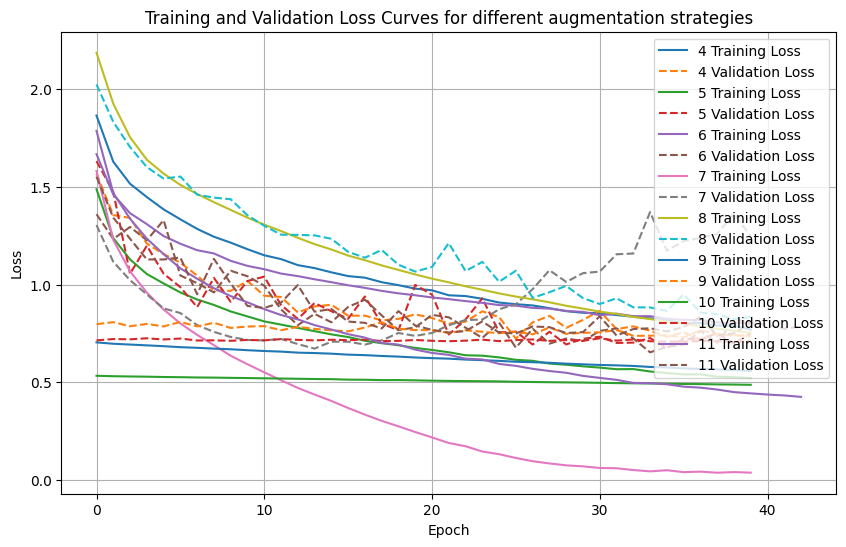


Best Validation Accuracy for Each Run:
+------------+----------------------------+
|   Strategy |   Best Validation Accuracy |
+============+============================+
|          4 |                     0.7639 |
+------------+----------------------------+
|          5 |                     0.7746 |
+------------+----------------------------+
|          6 |                     0.7804 |
+------------+----------------------------+
|          7 |                     0.7861 |
+------------+----------------------------+
|          8 |                     0.718  |
+------------+----------------------------+
|          9 |                     0.7485 |
+------------+----------------------------+
|         10 |                     0.7564 |
+------------+----------------------------+
|         11 |                     0.765  |
+------------+----------------------------+


In [ ]:
# List of history files
history_files = [
    '/content/drive/MyDrive/DeepLearning/03/history_m4.pkl',
    '/content/drive/MyDrive/DeepLearning/03/history_m5.pkl',
    '/content/drive/MyDrive/DeepLearning/03/history_m6.pkl',
    '/content/drive/MyDrive/DeepLearning/03/history_m7.pkl',
    '/content/drive/MyDrive/DeepLearning/03/history_m8.pkl',
    '/content/drive/MyDrive/DeepLearning/03/history_m9.pkl',
    '/content/drive/MyDrive/DeepLearning/03/history_m10.pkl',
    '/content/drive/MyDrive/DeepLearning/03/history_m11.pkl'
]
labels = [4,5,6,7,8,9,10,11]

# Dictionary to store loaded histories
histories = {}

# Load histories
for file_name, label in zip(history_files, labels):
    try:
        with open(file_name, 'rb') as file:
            histories[label] = pickle.load(file)
    except FileNotFoundError:
        print(f"File {file_name} not found.")
    except Exception as e:
        print(f"Error loading {file_name}: {e}")

# Plotting the loss curves
plt.figure(figsize=(10, 6))
for label, history in histories.items():
    if 'loss' in history and 'val_loss' in history:
        plt.plot(history['loss'], label=f'{label} Training Loss')
        plt.plot(history['val_loss'], linestyle='--', label=f'{label} Validation Loss')
    else:
        print(f"Loss data not found in {label}")

# Add plot details
plt.title('Training and Validation Loss Curves for different augmentation strategies')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Extract and display the best validation accuracy for each run
results = []
for label, history in histories.items():
    if 'val_accuracy' in history:
        best_val_accuracy = max(history['val_accuracy'])
        results.append([label, best_val_accuracy])
    else:
        print(f"No validation accuracy data found for {label}")

# Display the results in a table
if results:
    print("\nBest Validation Accuracy for Each Run:")
    print(tabulate(results, headers=["Strategy", "Best Validation Accuracy"], tablefmt="grid"))

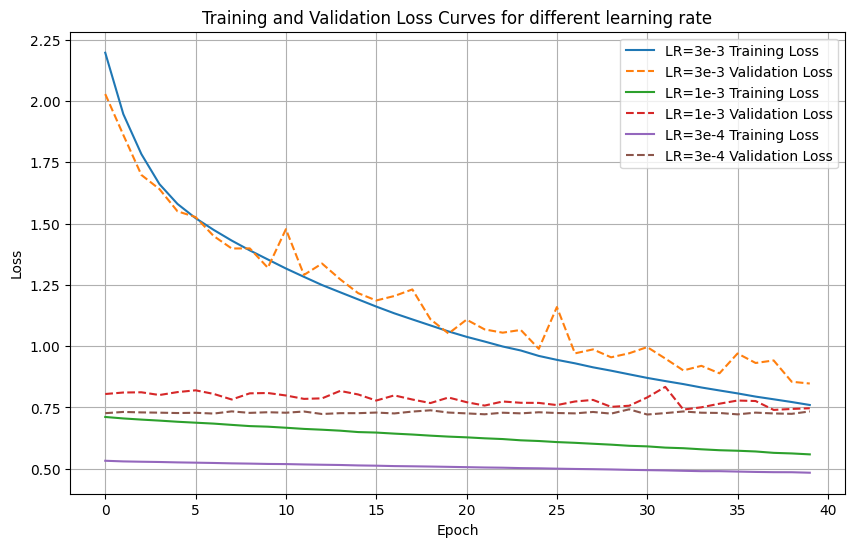


Best Validation Accuracy for Each Run:
+------------+----------------------------+
| Strategy   |   Best Validation Accuracy |
+============+============================+
| LR=3e-3    |                     0.6986 |
+------------+----------------------------+
| LR=1e-3    |                     0.7471 |
+------------+----------------------------+
| LR=3e-4    |                     0.7556 |
+------------+----------------------------+


In [ ]:
# List of history files
history_files = [
    '/content/drive/MyDrive/DeepLearning/03/history_m8.pkl',
    '/content/drive/MyDrive/DeepLearning/03/history_m9.pkl',
    '/content/drive/MyDrive/DeepLearning/03/history_m10.pkl',
]
labels = ["LR=3e-3","LR=1e-3","LR=3e-4"]

# Dictionary to store loaded histories
histories = {}

# Load histories
for file_name, label in zip(history_files, labels):
    try:
        with open(file_name, 'rb') as file:
            histories[label] = pickle.load(file)
    except FileNotFoundError:
        print(f"File {file_name} not found.")
    except Exception as e:
        print(f"Error loading {file_name}: {e}")

# Plotting the loss curves
plt.figure(figsize=(10, 6))
for label, history in histories.items():
    if 'loss' in history and 'val_loss' in history:
        plt.plot(history['loss'], label=f'{label} Training Loss')
        plt.plot(history['val_loss'], linestyle='--', label=f'{label} Validation Loss')
    else:
        print(f"Loss data not found in {label}")

# Add plot details
plt.title('Training and Validation Loss Curves for different learning rate')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Extract and display the best validation accuracy for each run
results = []
for label, history in histories.items():
    if 'val_accuracy' in history:
        best_val_accuracy = max(history['val_accuracy'])
        results.append([label, best_val_accuracy])
    else:
        print(f"No validation accuracy data found for {label}")

# Display the results in a table
if results:
    print("\nBest Validation Accuracy for Each Run:")
    print(tabulate(results, headers=["Strategy", "Best Validation Accuracy"], tablefmt="grid"))